# 초기 세팅

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [3]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [4]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [5]:
device = ('cuda' if torch.cuda.is_available() else 'cpu' ) # gpu('cuda')가 사용가능하면, gpu를 이용하도록 설정
device

'cuda'

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [6]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [7]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='/content',
                                 train=True, download=True,
                                 transform=CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root='/content',
                                 train=False, download=True,
                                 transform=CIFAR_transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# DataLoader

# batch-size = 4

train_loader = DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)

test_loader = DataLoader(testset, batch_size = 4, shuffle = True, num_workers = 2)

In [9]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

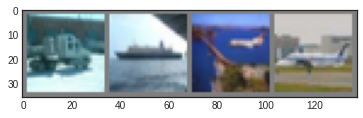

truck	 ship	 plane	 plane	


In [10]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [11]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()

      #input(3,32,32)
      self.conv_layers = nn.Sequential(
          nn.Conv2d(3,32,3,stride=1,padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(32),

          nn.Conv2d(32,32,3,stride=1,padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(32),

          nn.MaxPool2d(2),

          nn.Conv2d(32,64,3,stride=1,padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),

          nn.MaxPool2d(2),

          nn.Conv2d(64,128,3,stride=1,padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128),

          nn.Conv2d(128,128,3,stride=1,padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128),

          nn.MaxPool2d(2)
      )

      self.fc_layers = nn.Sequential(
          nn.Linear(128*4*4,100),
          nn.ReLU(),
          nn.Linear(100,10)
      )



    def forward(self,x):
      x = self.conv_layers(x)
      x = x.view(x.size(0),-1)
      x = self.fc_layers(x)

      return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

myNet = Net()
print(myNet)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [12]:
# 모델객체 생성
myNet= Net().to(device)

print(myNet)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [13]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [14]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [15]:
# 모델 구조 확인

summary(myNet, input_size=(3,32,32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 32, 32, 32]             896
              ReLU-2            [4, 32, 32, 32]               0
       BatchNorm2d-3            [4, 32, 32, 32]              64
            Conv2d-4            [4, 32, 32, 32]           9,248
              ReLU-5            [4, 32, 32, 32]               0
       BatchNorm2d-6            [4, 32, 32, 32]              64
         MaxPool2d-7            [4, 32, 16, 16]               0
            Conv2d-8            [4, 64, 16, 16]          18,496
              ReLU-9            [4, 64, 16, 16]               0
      BatchNorm2d-10            [4, 64, 16, 16]             128
        MaxPool2d-11              [4, 64, 8, 8]               0
           Conv2d-12             [4, 128, 8, 8]          73,856
             ReLU-13             [4, 128, 8, 8]               0
      BatchNorm2d-14             [4, 12

## 손실함수와 옵티마이저

In [16]:
criterion =  nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9)# SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [17]:
# epochs = 10

for epoch in range(30):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
                                 

        y_pred = myNet(inputs)            # y_pred
        loss = criterion(y_pred,labels)             # 손실함수를 이용해서 loss계산
        loss.backward()     # back-propagation
        optimizer.step()                     # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.6868296967893839
Epoch: 1, Batch: 4000, Loss: 1.3820499818325043
Epoch: 1, Batch: 6000, Loss: 1.2592878936324268
Epoch: 1, Batch: 8000, Loss: 1.129715545637533
Epoch: 1, Batch: 10000, Loss: 1.0907880577296019
Epoch: 1, Batch: 12000, Loss: 0.999677986552706
Epoch: 2, Batch: 2000, Loss: 0.8836010336373001
Epoch: 2, Batch: 4000, Loss: 0.8610772880506702
Epoch: 2, Batch: 6000, Loss: 0.86036480242759
Epoch: 2, Batch: 8000, Loss: 0.8069556527596433
Epoch: 2, Batch: 10000, Loss: 0.8026049978297669
Epoch: 2, Batch: 12000, Loss: 0.79293528515246
Epoch: 3, Batch: 2000, Loss: 0.6559820571867749
Epoch: 3, Batch: 4000, Loss: 0.6667531281831689
Epoch: 3, Batch: 6000, Loss: 0.678983497362191
Epoch: 3, Batch: 8000, Loss: 0.6562245617950102
Epoch: 3, Batch: 10000, Loss: 0.649819086891308
Epoch: 3, Batch: 12000, Loss: 0.6530073505599284
Epoch: 4, Batch: 2000, Loss: 0.5108897757035448
Epoch: 4, Batch: 4000, Loss: 0.5597194232271868
Epoch: 4, Batch: 6000, Loss: 0.52352160935

## 모델의 저장 및 로드

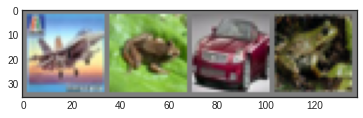

	plane 	frog 	car 	frog


In [18]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [19]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [20]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [21]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)            # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = myNet(images)                                            # y_pred
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

79.52


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [22]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 82.9%
Accuracy of car: 91.0%
Accuracy of bird: 74.7%
Accuracy of cat: 59.1%
Accuracy of deer: 80.8%
Accuracy of dog: 67.8%
Accuracy of frog: 85.0%
Accuracy of horse: 79.2%
Accuracy of ship: 86.2%
Accuracy of truck: 87.7%
